In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
import mxnet as mx
import numpy as np

from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import os
import sys
import math
import time
import pickle

proj_dir = os.getcwd()
label_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/labels')
lld_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/lld')

pickle_train_y_list = 'pickle_train_y_list'
pickle_train_x_list = 'pickle_train_x_list'

pickle_test_y_list = 'pickle_test_y_list'
pickle_test_x_list = 'pickle_test_x_list'

In [3]:
train_y_list = pickle.load(open(pickle_train_y_list))
train_x_list = pickle.load(open(pickle_train_x_list))

test_y_list = pickle.load(open(pickle_test_y_list))
test_x_list = pickle.load(open(pickle_test_x_list))

In [4]:
def calc_score(test_y_list, predict_y_list):
    print "Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):"
    print 'macro   : ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='macro')
    print 'weighted: ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='weighted')

In [5]:
# z-score normalization
scaler = preprocessing.StandardScaler().fit(train_x_list)
train_x_list = scaler.transform(train_x_list)
test_x_list = scaler.transform(test_x_list)

In [6]:
# PCA whiten
# pca = PCA(n_components='mle', svd_solver='full', whiten=True)
# x_pca = pca.fit(train_x_list)
# train_x_list = pca.transform(train_x_list)
# test_x_list = pca.transform(test_x_list)

In [7]:
# sklearn l1/l2 normalization
# x_normalizer = preprocessing.Normalizer(norm='l2').fit(train_x_list)
# train_x_list = x_normalizer.transform(train_x_list)
# test_x_list = x_normalizer.transform(test_x_list)

In [8]:
# # SMOTE up-sampling training data
# sm = SMOTE(kind='regular')
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)

# # split training data to 5 different classes
# train_x_lists = [[] for i in range(5)]
# for i in xrange(len(train_y_list)):
#     train_x_lists[int(train_y_list[i])].append(train_x_list[i])
# for i in xrange(5):
#     print 'number of class', i, ':', len(train_x_lists[i])

In [9]:
print train_y_list.shape, train_x_list.shape
print test_y_list.shape, test_x_list.shape

(9959,) (9959, 384)
(8257,) (8257, 384)


In [10]:
print train_x_list[0][:10]
print test_x_list[0][:10]

[-1.28200357  0.06173483 -1.28187449 -0.41449729  0.46579774 -1.17798747
  0.06471169 -0.85753636 -0.64435287 -1.27747438]
[-1.13903374 -0.75002097 -1.13420654 -0.43244806 -0.38227578 -1.17669163
  0.04549002 -0.83947808 -0.63455673 -1.16125476]


In [11]:
X = train_x_list
y = train_y_list

In [25]:
batch_size = 500
train_iter = mx.io.NDArrayIter(train_x_list, train_y_list, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(test_x_list, test_y_list, batch_size=batch_size)

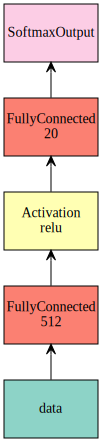

In [40]:
data = mx.symbol.Variable('data')
# data = mx.symbol.Dropout(data=data, p=0.2)
# fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=2048)
# act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2  = mx.symbol.FullyConnected(data = data, name = 'fc2', num_hidden = 512)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=20)
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

mx.viz.plot_network(mlp)

In [41]:
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

model = mx.model.FeedForward(
    ctx = mx.cpu(),       # Run on CPU
    symbol = mlp,         # Use the network we just defined
    num_epoch = 100,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001)         # Weight decay for regularization
model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter)#,  # Testing data set. MXNet computes scores on test set every epoch
    #batch_end_callback = mx.callback.Speedometer(batch_size, 2000))  # Logging module to print out progress

print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.151


start: 2016-12-26 18:18:31


INFO:root:Epoch[0] Validation-accuracy=0.629059
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.148
INFO:root:Epoch[1] Validation-accuracy=0.577529
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.174
INFO:root:Epoch[2] Validation-accuracy=0.575765
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.176
INFO:root:Epoch[3] Validation-accuracy=0.545176
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.174
INFO:root:Epoch[4] Validation-accuracy=0.634118
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.175
INFO:root:Epoch[5] Validation-accuracy=0.647529
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.178
INFO:root:Epoch[6] Validation-accuracy=0.622353
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.174
INFO:root:Epoch[7] Validation-accuracy=0.590824
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cos

start: 2016-12-26 18:18:54


In [42]:
predict_y_score_list = model.predict(test_x_list)
predict_y_list = np.argmax(predict_y_score_list, axis=1)

calc_score(test_y_list, predict_y_list)

Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34578519111372785, 0.32334790713994732, 0.32800549403105383, None)
weighted:  (0.57450441062827184, 0.60930119898268131, 0.58759070979772476, None)


In [31]:
batch_size = 500
train_iter = mx.io.NDArrayIter(train_x_list, train_y_list, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(test_x_list, test_y_list, batch_size=batch_size)

fc2_num_hidden_list = [64, 128, 256, 512, 1024]
fc3_num_hidden_list = [5, 10, 20]

for n2 in fc2_num_hidden_list:
    for n3 in fc3_num_hidden_list:
        print '(2-layer-MLP) ', 'fc2_num_hidden:', n2, ';',  'fc3_num_hidden:', n3
        
        data = mx.symbol.Variable('data')
        # data = mx.symbol.Dropout(data=data, p=0.2)
        # fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=2048)
        # act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
        fc2  = mx.symbol.FullyConnected(data = data, name = 'fc2', num_hidden = n2)
        act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
        fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=n3)
        mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')
        
        # mx.viz.plot_network(mlp)
        
        print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )
        model = mx.model.FeedForward(
            ctx = mx.cpu(),       # Run on CPU
            symbol = mlp,         # Use the network we just defined
            num_epoch = 100,       # Train for 10 epochs
            learning_rate = 0.1,  # Learning rate
            momentum = 0.9,       # Momentum for SGD with momentum
            wd = 0.00001)         # Weight decay for regularization
        model.fit(
            X=train_iter,  # Training data set
            eval_data=test_iter)#,  # Testing data set. MXNet computes scores on test set every epoch
            #batch_end_callback = mx.callback.Speedometer(batch_size, 2000))  # Logging module to print out progress
        print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )
        
        predict_y_score_list = model.predict(test_x_list)
        predict_y_list = np.argmax(predict_y_score_list, axis=1)
        calc_score(test_y_list, predict_y_list)
    
        print '-----------------------'

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.108
INFO:root:Epoch[0] Validation-accuracy=0.650353


(2-layer-MLP)  fc2_num_hidden: 64 ; fc3_num_hidden: 5
start: 2016-12-26 17:21:36


INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.088
INFO:root:Epoch[1] Validation-accuracy=0.648706
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.077
INFO:root:Epoch[2] Validation-accuracy=0.638824
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.068
INFO:root:Epoch[3] Validation-accuracy=0.628353
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.088
INFO:root:Epoch[4] Validation-accuracy=0.640706
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.073
INFO:root:Epoch[5] Validation-accuracy=0.639176
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.062
INFO:root:Epoch[6] Validation-accuracy=0.612706
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.073
INFO:root:Epoch[7] Validation-accuracy=0.587412
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cost=0.075
INFO:root:Epoch[8] Validation-accuracy=0

start: 2016-12-26 17:21:47
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30190162631905165, 0.28365367676450937, 0.28621067406365674, None)
weighted:  (0.53642454747004209, 0.57199951556255302, 0.54959533045024744, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 64 ; fc3_num_hidden: 10
start: 2016-12-26 17:21:47


INFO:root:Epoch[0] Validation-accuracy=0.668824
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.078
INFO:root:Epoch[1] Validation-accuracy=0.636941
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.075
INFO:root:Epoch[2] Validation-accuracy=0.634706
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.058
INFO:root:Epoch[3] Validation-accuracy=0.626941
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.106
INFO:root:Epoch[4] Validation-accuracy=0.624000
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.114
INFO:root:Epoch[5] Validation-accuracy=0.640000
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.061
INFO:root:Epoch[6] Validation-accuracy=0.642588
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.106
INFO:root:Epoch[7] Validation-accuracy=0.612588
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cos

start: 2016-12-26 17:21:58
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.29208010769164955, 0.28182261892868882, 0.27908891322359725, None)
weighted:  (0.52999239125486342, 0.5761172338621775, 0.5462132111126855, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 64 ; fc3_num_hidden: 20
start: 2016-12-26 17:21:58


INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.100
INFO:root:Epoch[1] Validation-accuracy=0.545529
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.082
INFO:root:Epoch[2] Validation-accuracy=0.520000
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.088
INFO:root:Epoch[3] Validation-accuracy=0.463647
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.085
INFO:root:Epoch[4] Validation-accuracy=0.599412
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.109
INFO:root:Epoch[5] Validation-accuracy=0.583647
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.056
INFO:root:Epoch[6] Validation-accuracy=0.606235
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.053
INFO:root:Epoch[7] Validation-accuracy=0.648706
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cost=0.056
INFO:root:Epoch[8] Validation-accuracy=0

start: 2016-12-26 17:22:11
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.29623355760704018, 0.30685254184207977, 0.29823270151065118, None)
weighted:  (0.55359143316958004, 0.53154898873682932, 0.54150924701504832, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 128 ; fc3_num_hidden: 5
start: 2016-12-26 17:22:11


INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.081
INFO:root:Epoch[1] Validation-accuracy=0.642000
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.103
INFO:root:Epoch[2] Validation-accuracy=0.623765
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.076
INFO:root:Epoch[3] Validation-accuracy=0.624118
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.076
INFO:root:Epoch[4] Validation-accuracy=0.639294
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.076
INFO:root:Epoch[5] Validation-accuracy=0.648706
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.121
INFO:root:Epoch[6] Validation-accuracy=0.630471
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.121
INFO:root:Epoch[7] Validation-accuracy=0.596235
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cost=0.085
INFO:root:Epoch[8] Validation-accuracy=0

start: 2016-12-26 17:22:25
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.33152116212051252, 0.31346312117887454, 0.31868695615142534, None)
weighted:  (0.56431311399968453, 0.59174034152840016, 0.57499221579666226, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 128 ; fc3_num_hidden: 10
start: 2016-12-26 17:22:26


INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.080
INFO:root:Epoch[1] Validation-accuracy=0.616824
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.075
INFO:root:Epoch[2] Validation-accuracy=0.612706
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.085
INFO:root:Epoch[3] Validation-accuracy=0.634824
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.084
INFO:root:Epoch[4] Validation-accuracy=0.637529
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.083
INFO:root:Epoch[5] Validation-accuracy=0.620471
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.079
INFO:root:Epoch[6] Validation-accuracy=0.559765
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.132
INFO:root:Epoch[7] Validation-accuracy=0.620118
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cost=0.081
INFO:root:Epoch[8] Validation-accuracy=0

start: 2016-12-26 17:22:41
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34045605526897538, 0.32891125802237031, 0.32811841713823126, None)
weighted:  (0.56812334224489336, 0.59016591982560251, 0.57558419260415761, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 128 ; fc3_num_hidden: 20
start: 2016-12-26 17:22:41


INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.095
INFO:root:Epoch[1] Validation-accuracy=0.573882
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.088
INFO:root:Epoch[2] Validation-accuracy=0.586824
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.087
INFO:root:Epoch[3] Validation-accuracy=0.528118
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.137
INFO:root:Epoch[4] Validation-accuracy=0.581176
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.080
INFO:root:Epoch[5] Validation-accuracy=0.659059
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.101
INFO:root:Epoch[6] Validation-accuracy=0.647176
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.103
INFO:root:Epoch[7] Validation-accuracy=0.635294
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cost=0.085
INFO:root:Epoch[8] Validation-accuracy=0

start: 2016-12-26 17:22:57
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32884179808071579, 0.3226711196244324, 0.31979496570187166, None)
weighted:  (0.5642557883510616, 0.58398934237616573, 0.57149263936830452, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 256 ; fc3_num_hidden: 5
start: 2016-12-26 17:22:57


INFO:root:Epoch[0] Validation-accuracy=0.652235
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.115
INFO:root:Epoch[1] Validation-accuracy=0.646471
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.112
INFO:root:Epoch[2] Validation-accuracy=0.633647
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.116
INFO:root:Epoch[3] Validation-accuracy=0.641765
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.112
INFO:root:Epoch[4] Validation-accuracy=0.643176
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.112
INFO:root:Epoch[5] Validation-accuracy=0.628941
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.110
INFO:root:Epoch[6] Validation-accuracy=0.605765
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.110
INFO:root:Epoch[7] Validation-accuracy=0.576824
INFO:root:Epoch[8] Resetting Data Iterator
INFO:root:Epoch[8] Time cos

start: 2016-12-26 17:23:18
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34080287368878925, 0.31975742558583914, 0.32446736193795911, None)
weighted:  (0.5695932892181268, 0.59985466876589555, 0.58087541692434241, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 256 ; fc3_num_hidden: 10
start: 2016-12-26 17:23:18


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.130
INFO:root:Epoch[0] Validation-accuracy=0.654235
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.120
INFO:root:Epoch[1] Validation-accuracy=0.601294
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.121
INFO:root:Epoch[2] Validation-accuracy=0.551294
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.126
INFO:root:Epoch[3] Validation-accuracy=0.610941
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.124
INFO:root:Epoch[4] Validation-accuracy=0.631529
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.122
INFO:root:Epoch[5] Validation-accuracy=0.642824
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.124
INFO:root:Epoch[6] Validation-accuracy=0.639882
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.115
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:23:37
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34138298671756584, 0.32381369782433189, 0.32761092219946264, None)
weighted:  (0.57484411990673656, 0.60179241855395427, 0.58519040598211924, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 256 ; fc3_num_hidden: 20
start: 2016-12-26 17:23:37


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.174
INFO:root:Epoch[0] Validation-accuracy=0.661529
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.123
INFO:root:Epoch[1] Validation-accuracy=0.562588
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.137
INFO:root:Epoch[2] Validation-accuracy=0.574588
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.156
INFO:root:Epoch[3] Validation-accuracy=0.594000
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.116
INFO:root:Epoch[4] Validation-accuracy=0.571882
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.148
INFO:root:Epoch[5] Validation-accuracy=0.611176
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.138
INFO:root:Epoch[6] Validation-accuracy=0.643412
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.131
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:23:57
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34252755725092021, 0.32328532724244957, 0.32787254696667023, None)
weighted:  (0.57030140424230991, 0.59670582536030037, 0.58050338282693659, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 512 ; fc3_num_hidden: 5
start: 2016-12-26 17:23:57


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.201
INFO:root:Epoch[0] Validation-accuracy=0.656588
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.197
INFO:root:Epoch[1] Validation-accuracy=0.617882
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.201
INFO:root:Epoch[2] Validation-accuracy=0.614471
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.198
INFO:root:Epoch[3] Validation-accuracy=0.637882
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.198
INFO:root:Epoch[4] Validation-accuracy=0.634588
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.198
INFO:root:Epoch[5] Validation-accuracy=0.598353
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.200
INFO:root:Epoch[6] Validation-accuracy=0.583059
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.201
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:24:27
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.34620644625170927, 0.33031862614101776, 0.33288933461606535, None)
weighted:  (0.57562372986927035, 0.60179241855395427, 0.58558882221959174, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 512 ; fc3_num_hidden: 10
start: 2016-12-26 17:24:28


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.231
INFO:root:Epoch[0] Validation-accuracy=0.659529
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.301
INFO:root:Epoch[1] Validation-accuracy=0.555059
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.206
INFO:root:Epoch[2] Validation-accuracy=0.580000
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.203
INFO:root:Epoch[3] Validation-accuracy=0.601412
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.201
INFO:root:Epoch[4] Validation-accuracy=0.644471
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.229
INFO:root:Epoch[5] Validation-accuracy=0.639529
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.183
INFO:root:Epoch[6] Validation-accuracy=0.617176
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.308
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:25:00
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.33915208364440919, 0.31929957008016091, 0.32151392226609066, None)
weighted:  (0.56483758837867593, 0.60046021557466389, 0.57792835773853879, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 512 ; fc3_num_hidden: 20
start: 2016-12-26 17:25:00


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.210
INFO:root:Epoch[0] Validation-accuracy=0.634000
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.210
INFO:root:Epoch[1] Validation-accuracy=0.534471
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.213
INFO:root:Epoch[2] Validation-accuracy=0.544588
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.207
INFO:root:Epoch[3] Validation-accuracy=0.578118
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.209
INFO:root:Epoch[4] Validation-accuracy=0.644000
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.208
INFO:root:Epoch[5] Validation-accuracy=0.657294
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.209
INFO:root:Epoch[6] Validation-accuracy=0.634471
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.208
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:25:33
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.35213268758719862, 0.33131162355207178, 0.33418669092606484, None)
weighted:  (0.57529106589591616, 0.60603124621533244, 0.58656997175756442, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 1024 ; fc3_num_hidden: 5
start: 2016-12-26 17:25:33


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.425
INFO:root:Epoch[0] Validation-accuracy=0.653176
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.400
INFO:root:Epoch[1] Validation-accuracy=0.588588
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.387
INFO:root:Epoch[2] Validation-accuracy=0.580588
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.397
INFO:root:Epoch[3] Validation-accuracy=0.634471
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.405
INFO:root:Epoch[4] Validation-accuracy=0.639294
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.441
INFO:root:Epoch[5] Validation-accuracy=0.600941
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.428
INFO:root:Epoch[6] Validation-accuracy=0.565882
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.459
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:26:30
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.356859761507615, 0.32064998304997644, 0.32974241892613509, None)
weighted:  (0.57874582577900968, 0.61487222962334986, 0.59129642632679835, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 1024 ; fc3_num_hidden: 10
start: 2016-12-26 17:26:30


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.386
INFO:root:Epoch[0] Validation-accuracy=0.618471
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.363
INFO:root:Epoch[1] Validation-accuracy=0.540588
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.413
INFO:root:Epoch[2] Validation-accuracy=0.500000
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.481
INFO:root:Epoch[3] Validation-accuracy=0.556000
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.498
INFO:root:Epoch[4] Validation-accuracy=0.606824
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.595
INFO:root:Epoch[5] Validation-accuracy=0.639882
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.395
INFO:root:Epoch[6] Validation-accuracy=0.629647
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.424
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:27:32
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.35313600733976663, 0.32337540115201641, 0.33037168181461823, None)
weighted:  (0.5761087913276659, 0.61269226111178399, 0.58948617932688452, None)
-----------------------
(2-layer-MLP)  fc2_num_hidden: 1024 ; fc3_num_hidden: 20
start: 2016-12-26 17:27:32


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.418
INFO:root:Epoch[0] Validation-accuracy=0.640941
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.409
INFO:root:Epoch[1] Validation-accuracy=0.424941
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.372
INFO:root:Epoch[2] Validation-accuracy=0.536471
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.391
INFO:root:Epoch[3] Validation-accuracy=0.592235
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.394
INFO:root:Epoch[4] Validation-accuracy=0.613529
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.394
INFO:root:Epoch[5] Validation-accuracy=0.574000
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.644
INFO:root:Epoch[6] Validation-accuracy=0.568000
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.555
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 17:28:32
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.35058732744680049, 0.32017464389693973, 0.32858961035831846, None)
weighted:  (0.57385324751057931, 0.61063340196197169, 0.58760441549397413, None)
-----------------------


In [34]:
print predict_y_list[:100]

[2 2 2 2 2 4 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 4 0 2 2 4 2 4 1 2 2 2 2 2 1 2
 2 2 2 2 2 0 2 2 1 1 2 1 2 2 2 2 2 1 2 2 4 2 2 2 2 4 2 4 1 2 2 2 2 2 2 1 1
 1 2 1 2 1 2 2 2 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1]


In [35]:
print test_y_list[:100]

[2 2 2 2 2 4 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2
 1 1 1 2 1 1 1 1 1 2 2 1 1 1 2 1 1 2 2 2 2 2 1 1 1 2]
